In [4]:
import itertools
import platform
import random
from collections import Counter
from itertools import chain, combinations
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import polars as pl
from platformdirs import user_documents_dir

In [5]:
cfg = pl.Config()
# cfg.set_tbl_rows(100)
cfg.set_tbl_width_chars(200)
cfg.set_fmt_str_lengths(200)

polars.config.Config

In [6]:
environment = platform.system()
# Setup the directories
documents_dir = Path(user_documents_dir())
if platform.system() == "Windows":
    class_root_dir = documents_dir.joinpath("01-Berkeley/210")
    project_root_dir = class_root_dir.joinpath("gotmeals")
    data_root_dir = class_root_dir.joinpath("data")
elif platform.system() == "Linux":
    class_root_dir = Path("/tf/notebooks")
    project_root_dir = class_root_dir.joinpath("gotmeals")
    data_root_dir = class_root_dir.joinpath("data")

rnlg_data_dir = data_root_dir.joinpath("RecipeDatabase")
rnlg_csv_file = rnlg_data_dir.joinpath("RecipeNLG_dataset.csv")
rnlg_parquet_file = rnlg_data_dir.joinpath("RecipeNLG_dataset.parquet")

if not rnlg_parquet_file.exists():
    raise FileNotFoundError(f"{rnlg_parquet_file} not found")

In [7]:
df = pl.read_parquet(rnlg_parquet_file)

In [8]:
all_ingredient_counts = Counter(
    item for sublist in df["NER"].to_numpy() for item in sublist
)

In [9]:
# Check for Nulls
df.select(pl.all().is_null().sum())

id,title,ingredients,directions,link,source,NER,NER_len,directions_len,ingredients_len
u32,u32,u32,u32,u32,u32,u32,u32,u32,u32
0,0,0,0,0,0,0,0,0,0


In [10]:
ingredient_list = [
    {"item": key, "count": value} for key, value in all_ingredient_counts.items()
]
ingredient_df = pl.DataFrame(ingredient_list)
ingredient_df = ingredient_df.rename({"item": "ingredient"})
ingredient_df = ingredient_df.sort(["count", "ingredient"], descending=True)
ingredient_df.head(10)

ingredient,count
str,i64
"""salt""",1014100
"""sugar""",664180
"""butter""",540279
"""flour""",492380
"""eggs""",422427
"""onion""",391395
"""garlic""",388239
"""milk""",373124
"""water""",351598


In [11]:
# Number of ingredients used more than 15,000 times
filtered_ingredients = ingredient_df.filter(ingredient_df["count"] >= 15000)
print(filtered_ingredients.shape)
filtered_ingredients.head(12)

(193, 2)


ingredient,count
str,i64
"""salt""",1014100
"""sugar""",664180
"""butter""",540279
"""flour""",492380
"""eggs""",422427
"""onion""",391395
"""garlic""",388239
"""milk""",373124
"""water""",351598


In [12]:
def powerset(iterable):
    "powerset([1,2,3]) --> () (1,) (2,) (3,) (1,2) (1,3) (2,3) (1,2,3)"
    s = list(iterable)
    return chain.from_iterable(combinations(s, r) for r in range(1, len(s) + 1))

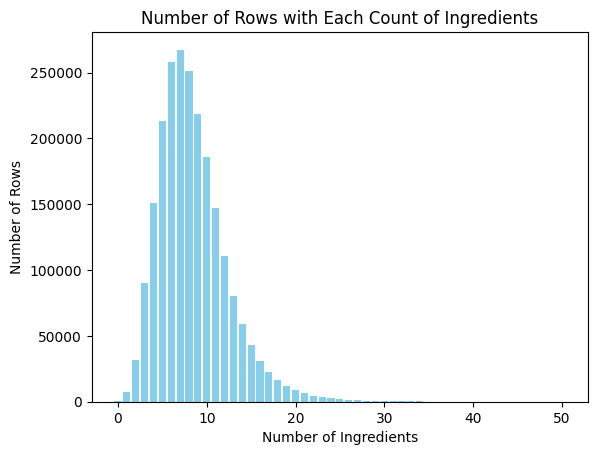

In [13]:
counts = df.group_by("NER_len").len().sort("NER_len", descending=False)
counts_filtered = counts.filter(counts["NER_len"] <= 50)
x_values = counts_filtered["NER_len"].to_numpy()
y_values = counts_filtered["len"].to_numpy()
plt.bar(x_values, y_values, color="skyblue")
plt.xlabel("Number of Ingredients")
plt.ylabel("Number of Rows")
plt.title("Number of Rows with Each Count of Ingredients")
plt.show()

In [14]:
single_ingredients = ingredient_df.filter(ingredient_df["count"] == 1)
single_ingredients

ingredient,count
str,i64
"""ｗalnuts""",1
"""ﬂour tortillas""",1
"""ﬂat leaf parsley""",1
"""玫瑰露酒""",1
"""木綿豆腐""",1
"""špek""",1
"""ñora pepper""",1
"""ñame""",1
"""étouffée""",1


In [15]:
image_ingredients = pl.read_parquet("unique_ingredients.parquet")
common_ingredients = []
for i, my_ingredient in enumerate(image_ingredients["ClassId"].to_list()):
    df_filtered = df.filter(df["NER"].list.contains(my_ingredient))
    if df_filtered.height > 0:
        common_ingredients.append(my_ingredient)
print("Matched Ingredients: ", len(common_ingredients))

Matched Ingredients:  77


In [17]:
sample_common_ingredients = random.sample(common_ingredients, 12)
variations = list(powerset(sample_common_ingredients))
total_recipes_matched = 0
for i, v in enumerate(variations):
    match_ner_count = df.filter(pl.col("NER_len") == len(v))
    final_df = match_ner_count.filter(
        pl.all_horizontal(pl.lit(item).is_in(pl.col("NER")) for item in v)
    )
    if final_df.height > 0:
        print(
            f"Case:\t{i:-4d} of {len(variations):-4d}\tMatched: {final_df.height:-4d} recipes"
        )
        total_recipes_matched += final_df.height
    else:
        pass
    # print("="*80)
print(
    f"Total Recipes Matched: {total_recipes_matched} for {len(variations)} variations"
)

Case:	   0 of 4095	Matched:   17 recipes
Case:	   2 of 4095	Matched:   10 recipes
Case:	   3 of 4095	Matched:    1 recipes
Case:	   4 of 4095	Matched:   10 recipes
Case:	   5 of 4095	Matched:    4 recipes
Case:	   6 of 4095	Matched:    7 recipes
Case:	   7 of 4095	Matched:    2 recipes
Case:	   8 of 4095	Matched:    5 recipes
Case:	   9 of 4095	Matched:    4 recipes
Case:	  10 of 4095	Matched:    1 recipes
Case:	  11 of 4095	Matched:    8 recipes
Case:	  19 of 4095	Matched:    1 recipes
Case:	  57 of 4095	Matched:    1 recipes
Total Recipes Matched: 71 for 4095 variations


In [47]:
short_list = filtered_ingredients.head(12)
variations = list(powerset(short_list["ingredient"].to_list()))
total_recipes_matched = 0
for i, v in enumerate(variations):
    match_ner_count = df.filter(pl.col("NER_len") == len(v))
    final_df = match_ner_count.filter(
        pl.all_horizontal(pl.lit(item).is_in(pl.col("NER")) for item in v)
    )
    if final_df.height > 0:
        print(
            f"Case:\t{i:-4d} of {len(variations):-4d}\tMatched: {final_df.height:-4d} recipes"
        )
        total_recipes_matched += final_df.height
    else:
        pass
    # print("="*80)
print(
    f"Total Recipes Matched: {total_recipes_matched} for {len(variations)} variations"
)

Case:	   0 of 4095	Matched:   86 recipes
Case:	   1 of 4095	Matched:  150 recipes
Case:	   2 of 4095	Matched:  128 recipes
Case:	   3 of 4095	Matched:   39 recipes
Case:	   4 of 4095	Matched:  101 recipes
Case:	   5 of 4095	Matched:   22 recipes
Case:	   6 of 4095	Matched:   37 recipes
Case:	   7 of 4095	Matched:  103 recipes
Case:	   8 of 4095	Matched:  143 recipes
Case:	   9 of 4095	Matched:   12 recipes
Case:	  10 of 4095	Matched:   27 recipes
Case:	  11 of 4095	Matched:    7 recipes
Case:	  12 of 4095	Matched:   11 recipes
Case:	  13 of 4095	Matched:   28 recipes
Case:	  14 of 4095	Matched:   25 recipes
Case:	  15 of 4095	Matched:   24 recipes
Case:	  16 of 4095	Matched:    6 recipes
Case:	  17 of 4095	Matched:   13 recipes
Case:	  18 of 4095	Matched:    5 recipes
Case:	  19 of 4095	Matched:   38 recipes
Case:	  21 of 4095	Matched:   43 recipes
Case:	  22 of 4095	Matched:   11 recipes
Case:	  23 of 4095	Matched:   21 recipes
Case:	  24 of 4095	Matched:   63 recipes
Case:	  25 of 40